# Modern Pandas (Part 3)

* see: https://github.com/TomAugspurger/effective-pandas
* see: https://tomaugspurger.github.io/modern-3-indexes

In [2]:
%matplotlib inline

import json
import glob
import datetime
from io import StringIO

import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')

import os

In [3]:
states = """AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME
 MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT
 WA WI WV WY""".split()

# IEM has Iowa AWOS sites in its own labeled network
networks = ['AWOS'] + ['{}_ASOS'.format(state) for state in states]

In [4]:
def get_weather(stations, start=pd.Timestamp('2014-01-01'), end=pd.Timestamp('2014-01-31')):
    '''
    Fetch weather data from MESONet between ``start`` and ``stop``.
    '''
   
    url = ("http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"
           "&data=tmpf&data=relh&data=sped&data=mslp&data=p01i&data=vsby&data=gust_mph&data=skyc1&data=skyc2&data=skyc3"
           "&tz=Etc/UTC&format=comma&latlon=no"
           "&{start:year1=%Y&month1=%m&day1=%d}"
           "&{end:year2=%Y&month2=%m&day2=%d}&{stations}")
    
    
    stations = "&".join("station={}".format(s) for s in stations)
    weather = (pd.read_csv(url.format(start=start, end=end, stations=stations), comment='#')
                             .rename(columns={'valid': 'date'})
                             .rename(columns=str.strip)
                             .assign(date=lambda df: pd.to_datetime(df['date']))
                             .set_index(['station', 'date'])
                             .sort_index())
    
    float_cols = ['tmpf', 'relh', 'sped', 'mslp', 'p01i', 'vsby', 'gust_mph']
    weather[float_cols] = weather[float_cols].apply(pd.to_numeric, errors='corce')
    
    return weather

In [5]:
def get_ids(network):
    url = "http://mesonet.agron.iastate.edu/geojson/network.php?network={}"
    r = requests.get(url.format(network))
    md = pd.io.json.json_normalize(r.json()['features'])
    md['network'] = network
    return md

In [6]:
get_ids('AWOS').head()

,geometry.coordinates,geometry.type,id,properties.climate_site,properties.country,properties.county,properties.elevation,properties.ncdc81,properties.sid,properties.sname,properties.state,properties.tzname,properties.ugc_county,properties.ugc_zone,properties.wfo,type,network
0,"[-94.2724, 43.0796]",Point,AXA,IA0133,US,Kossuth,368.8,USC00130133,AXA,ALGONA,IA,America/Chicago,IAC109,IAZ005,DMX,Feature,AWOS
1,"[-93.5695, 41.6878]",Point,IKV,IA0241,US,Polk,270.7,USC00130241,IKV,ANKENY,IA,America/Chicago,IAC153,IAZ060,DMX,Feature,AWOS
2,"[-95.0465, 41.4059]",Point,AIO,IA0364,US,Cass,351.7,USC00130364,AIO,ATLANTIC,IA,America/Chicago,IAC029,IAZ070,DMX,Feature,AWOS
3,"[-94.9204, 41.6994]",Point,ADU,IA0385,US,Audubon,399.3,USC00130385,ADU,AUDUBON,IA,America/Chicago,IAC009,IAZ057,DMX,Feature,AWOS
4,"[-93.8486, 42.0486]",Point,BNW,IA0807,US,Boone,349.3,USC00130807,BNW,BOONE MUNI,IA,America/Chicago,IAC015,IAZ047,DMX,Feature,AWOS


# Main

In [7]:
ids = pd.concat([get_ids(network) for network in networks], ignore_index=True)

In [8]:
ids

,geometry.coordinates,geometry.type,id,properties.climate_site,properties.country,properties.county,properties.elevation,properties.ncdc81,properties.sid,properties.sname,properties.state,properties.tzname,properties.ugc_county,properties.ugc_zone,properties.wfo,type,network
0,"[-94.2724, 43.0796]",Point,AXA,IA0133,US,Kossuth,368.800,USC00130133,AXA,ALGONA,IA,America/Chicago,IAC109,IAZ005,DMX,Feature,AWOS
1,"[-93.5695, 41.6878]",Point,IKV,IA0241,US,Polk,270.700,USC00130241,IKV,ANKENY,IA,America/Chicago,IAC153,IAZ060,DMX,Feature,AWOS
2,"[-95.0465, 41.4059]",Point,AIO,IA0364,US,Cass,351.700,USC00130364,AIO,ATLANTIC,IA,America/Chicago,IAC029,IAZ070,DMX,Feature,AWOS
3,"[-94.9204, 41.6994]",Point,ADU,IA0385,US,Audubon,399.300,USC00130385,ADU,AUDUBON,IA,America/Chicago,IAC009,IAZ057,DMX,Feature,AWOS
4,"[-93.8486, 42.0486]",Point,BNW,IA0807,US,Boone,349.300,USC00130807,BNW,BOONE MUNI,IA,America/Chicago,IAC015,IAZ047,DMX,Feature,AWOS
5,"[-94.7889, 42.0444]",Point,CIN,IA1233,US,Carroll,365.200,USC00131233,CIN,CARROLL,IA,America/Chicago,IAC027,IAZ045,DMX,Feature,AWOS
6,"[-92.8983, 40.6832]",Point,TVK,IA1354,US,Appanoose,313.000,USC00131354,TVK,Centerville,IA,America/Chicago,IAC007,IAZ096,DMX,Feature,AWOS
7,"[-93.3608, 41.0184]",Point,CNC,IA1394,US,Lucas,319.100,USC00131394,CNC,CHARITON,IA,America/Chicago,IAC117,IAZ084,DMX,Feature,AWOS
8,"[-92.6132, 43.073]",Point,CCY,IA1402,US,Floyd,340.200,USC00131402,CCY,CHARLES CITY,IA,America/Chicago,IAC067,IAZ018,ARX,Feature,AWOS
9,"[-95.5538, 42.7304]",Point,CKP,IA1442,US,Cherokee,373.700,USC00131442,CKP,Cherokee,IA,America/Chicago,IAC035,IAZ301,FSD,Feature,AWOS


In [10]:
gr = ids.groupby('network')

In [11]:
os.makedirs('weather', exist_ok=True)

In [12]:
for i, (k, v) in enumerate(gr):
    print("{}/{}".format(i+1, len(networks)))
    weather = get_weather(v['id'])
    weather.to_csv("weather/{}.csv".format(k))
    
weather = pd.concat([pd.read_csv(f, parse_dates=['date'], index_col=['station', 'date']) for f in  glob.glob('weather/*.csv')])
weather.to_hdf("weather.h5", "weather")

1/51


/Users/yuki/.pyenv/versions/miniconda3-4.1.11/envs/ml_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


2/51
3/51
4/51
5/51
6/51
7/51
8/51
9/51
10/51
11/51
12/51
13/51
14/51
15/51
16/51
17/51
18/51
19/51
20/51
21/51
22/51
23/51
24/51


/Users/yuki/.pyenv/versions/miniconda3-4.1.11/envs/ml_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


25/51
26/51
27/51
28/51
29/51
30/51
31/51
32/51
33/51
34/51
35/51
36/51
37/51
38/51
39/51
40/51
41/51
42/51
43/51
44/51
45/51
46/51
47/51
48/51
49/51
50/51
51/51


In [14]:
weather.to_hdf("weather.h5", "weather")

read from h5

In [9]:
weather = pd.read_hdf("weather.h5", "weather").sort_index()

In [10]:
weather.head()

tmpf   relh  sped  mslp  p01i  vsby  gust_mph  \
station date                                                                  
01M     2014-01-01 00:15:00  33.80  85.86   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 00:35:00  33.44  87.11   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 00:55:00  32.54  90.97   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 01:15:00  31.82  93.65   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 01:35:00  32.00  92.97   0.0   NaN   0.0  10.0       NaN   

                            skyc1 skyc2 skyc3  
station date                                   
01M     2014-01-01 00:15:00   CLR     M     M  
        2014-01-01 00:35:00   CLR     M     M  
        2014-01-01 00:55:00   CLR     M     M  
        2014-01-01 01:15:00   CLR     M     M  
        2014-01-01 01:35:00   CLR     M     M

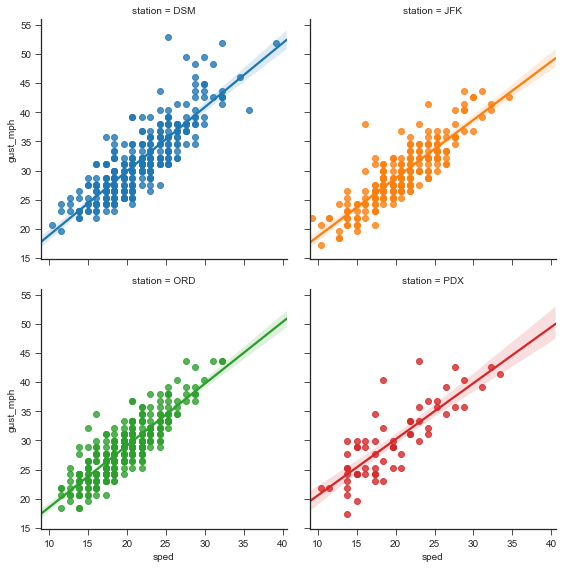

In [11]:
airports = ['DSM', 'ORD', 'JFK', 'PDX']

g = sns.FacetGrid(weather.sort_index().loc[airports].reset_index(), col='station', hue='station', col_wrap=2, size=4)
g.map(sns.regplot, 'sped', 'gust_mph')

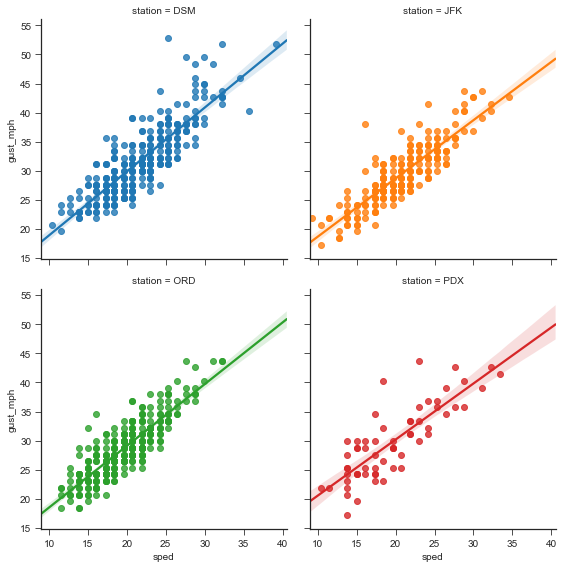

In [12]:
airports = ['DSM', 'ORD', 'JFK', 'PDX']

g = sns.FacetGrid(weather.sort_index().loc[airports].reset_index(), col='station', hue='station', col_wrap=2, size=4)
g.map(sns.regplot, 'sped', 'gust_mph')

# Set Operations

In [13]:
flights = pd.read_hdf('data/flights.h5', 'flights')

In [14]:
flights.head()

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin,origin_city_name,...,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2017-01-01,AA,19805,N787AA,1,12478,1247803,31703,JFK,New York,...,2017-01-01 11:42:00,2017-01-01 12:09:00,27.0,0.0,NaN,27.0,0.0,0.0,0.0,0.0
1,2017-01-01,AA,19805,N783AA,2,12892,1289204,32575,LAX,Los Angeles,...,2017-01-01 17:27:00,2017-01-01 18:09:00,42.0,0.0,NaN,34.0,0.0,8.0,0.0,0.0
2,2017-01-01,AA,19805,N791AA,4,12892,1289204,32575,LAX,Los Angeles,...,2017-01-01 19:58:00,2017-01-01 20:40:00,42.0,0.0,NaN,7.0,0.0,0.0,0.0,35.0
3,2017-01-01,AA,19805,N391AA,5,11298,1129804,30194,DFW,Dallas/Fort Worth,...,2017-01-01 16:12:00,2017-01-01 17:49:00,97.0,0.0,NaN,77.0,0.0,20.0,0.0,0.0
4,2017-01-01,AA,19805,N346AA,6,13830,1383002,33830,OGG,Kahului,...,2017-01-01 06:00:00,2017-01-01 06:42:00,42.0,0.0,NaN,0.0,0.0,42.0,0.0,0.0


In [15]:
weather.index.levels

FrozenList([['01M', '04V', '04W', '05U', '06D', '08D', '0A9', '0CO', '0E0', '0F2', '0J4', '0VG', '11R', '12N', '14Y', '19A', '1A5', '1A6', '1B7', '1F0', '1H2', '1J0', '1M4', '1P1', '1R7', '1V4', '1V6', '1YT', '20V', '21D', '28J', '2C8', '2D5', '2DP', '2G4', '2I0', '2J9', '2V5', '2W6', '2WX', '33V', '36U', '3I2', '3J7', '3LF', '3MW', '3R7', '3T5', '40J', '42J', '46D', '4A6', '4A9', '4BM', '4I3', '4M9', '4MR', '4O4', '54J', '5C1', '5H4', '5M9', '5R8', '5SM', '5T6', '5W8', '65S', '6A2', '6B0', '6R3', '6R6', '79J', '7BM', '7L2', '7R3', '7R4', '82V', '8A0', '8D3', '8S0', '96D', '9D7', '9F2', '9L2', '9MN', '9V9', 'AAA', 'AAF', 'AAO', 'AAT', 'ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACB', 'ACJ', 'ACK', 'ACP', 'ACQ', ...], [2014-01-01 00:00:00, 2014-01-01 00:01:00, 2014-01-01 00:02:00, 2014-01-01 00:03:00, 2014-01-01 00:04:00, 2014-01-01 00:05:00, 2014-01-01 00:06:00, 2014-01-01 00:07:00, 2014-01-01 00:08:00, 2014-01-01 00:09:00, 2014-01-01 00:10:00, 2014-01-01 00:11:00, 2014-01-01 00:12:00, 2014-01

In [17]:
len(weather.index.levels)

2

In [20]:
weather_locs = weather.index.levels[0]
weather_locs

Index(['01M', '04V', '04W', '05U', '06D', '08D', '0A9', '0CO', '0E0', '0F2',
       ...
       'Y50', 'Y51', 'Y63', 'Y70', 'YIP', 'YKM', 'YKN', 'YNG', 'ZPH', 'ZZV'],
      dtype='object', name='station', length=2176)

In [25]:
origin_locs = flights.origin.cat.categories
origin_locs

Index(['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACT', 'ACV', 'ACY', 'ADK', 'ADQ',
       ...
       'TWF', 'TXK', 'TYR', 'TYS', 'VLD', 'VPS', 'WRG', 'XNA', 'YAK', 'YUM'],
      dtype='object', length=298)

In [26]:
dest_locs = flights.dest.cat.categories
dest_locs

Index(['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACT', 'ACV', 'ACY', 'ADK', 'ADQ',
       ...
       'TWF', 'TXK', 'TYR', 'TYS', 'VLD', 'VPS', 'WRG', 'XNA', 'YAK', 'YUM'],
      dtype='object', length=297)

In [28]:
airports = weather_locs & origin_locs & dest_locs
airports

Index(['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACT', 'ACV', 'ACY', 'AEX', 'AGS',
       ...
       'TUL', 'TUS', 'TVC', 'TWF', 'TXK', 'TYR', 'TYS', 'VLD', 'VPS', 'XNA'],
      dtype='object', length=265)

In [32]:
print("Weather, no flights:\n\t", weather_locs.difference(origin_locs | dest_locs), end='\n\n')
print("Flights, no weather:\n\t", (origin_locs | dest_locs).difference(weather_locs), end='\n\n')
print("Dropped Stations:\n\t", (origin_locs | dest_locs) ^ weather_locs)

Weather, no flights:
	 Index(['01M', '04V', '04W', '05U', '06D', '08D', '0A9', '0CO', '0E0', '0F2',
       ...
       'Y50', 'Y51', 'Y63', 'Y70', 'YIP', 'YKM', 'YKN', 'YNG', 'ZPH', 'ZZV'],
      dtype='object', length=1910)

Flights, no weather:
	 Index(['ADK', 'ADQ', 'ANC', 'BET', 'BQN', 'BRW', 'CDV', 'FAI', 'FCA', 'GUM',
       'HNL', 'ITO', 'JNU', 'KOA', 'KTN', 'LIH', 'MQT', 'OGG', 'OME', 'OTZ',
       'PPG', 'PSE', 'PSG', 'SCC', 'SCE', 'SIT', 'SJU', 'STT', 'STX', 'WRG',
       'YAK', 'YUM'],
      dtype='object')

Dropped Stations:
	 Index(['01M', '04V', '04W', '05U', '06D', '08D', '0A9', '0CO', '0E0', '0F2',
       ...
       'Y63', 'Y70', 'YAK', 'YIP', 'YKM', 'YKN', 'YNG', 'YUM', 'ZPH', 'ZZV'],
      dtype='object', length=1942)


Weather no flights

In [39]:
weather.loc['01M'].head()

,tmpf,relh,sped,mslp,p01i,vsby,gust_mph,skyc1,skyc2,skyc3
date,,,,,,,,,,
2014-01-01 00:15:00,33.80,85.86,0.0,NaN,0.0,10.0,NaN,CLR,M,M
2014-01-01 00:35:00,33.44,87.11,0.0,NaN,0.0,10.0,NaN,CLR,M,M
2014-01-01 00:55:00,32.54,90.97,0.0,NaN,0.0,10.0,NaN,CLR,M,M
2014-01-01 01:15:00,31.82,93.65,0.0,NaN,0.0,10.0,NaN,CLR,M,M
2014-01-01 01:35:00,32.00,92.97,0.0,NaN,0.0,10.0,NaN,CLR,M,M


In [52]:
flights[flights.origin == '01M']

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin,origin_city_name,...,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay


In [53]:
flights[flights.dest == '01M']

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin,origin_city_name,...,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay


Flights no weather

In [50]:
'ADK' in weather.index.levels[0]

False

In [55]:
flights[flights.origin == 'ADK'].head()

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin,origin_city_name,...,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
5397,2017-01-01,AS,19930,N762AS,161,10165,1016504,30165,ADK,Adak Island,...,2017-01-01 21:00:00,2017-01-01 21:26:00,26.0,0.0,NaN,0.0,6.0,6.0,0.0,14.0
67622,2017-01-05,AS,19930,N764AS,161,10165,1016504,30165,ADK,Adak Island,...,2017-01-05 21:00:00,2017-01-05 20:34:00,-26.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
102874,2017-01-08,AS,19930,N791AS,161,10165,1016504,30165,ADK,Adak Island,...,2017-01-08 21:00:00,2017-01-08 20:56:00,-4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
162105,2017-01-12,AS,19930,N767AS,161,10165,1016504,30165,ADK,Adak Island,...,2017-01-12 21:00:00,2017-01-12 21:07:00,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
204509,2017-01-15,AS,19930,N765AS,161,10165,1016504,30165,ADK,Adak Island,...,2017-01-15 21:00:00,2017-01-15 20:43:00,-17.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
flights[flights.dest == 'ADK'].head()

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin,origin_city_name,...,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
5398,2017-01-01,AS,19930,N762AS,164,10299,1029904,30299,ANC,Anchorage,...,2017-01-01 16:20:00,2017-01-01 16:49:00,29.0,0.0,NaN,0.0,0.0,0.0,0.0,29.0
67623,2017-01-05,AS,19930,N764AS,164,10299,1029904,30299,ANC,Anchorage,...,2017-01-05 16:20:00,2017-01-05 15:45:00,-35.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
102875,2017-01-08,AS,19930,N791AS,164,10299,1029904,30299,ANC,Anchorage,...,2017-01-08 16:20:00,2017-01-08 15:54:00,-26.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
162106,2017-01-12,AS,19930,N767AS,164,10299,1029904,30299,ANC,Anchorage,...,2017-01-12 16:10:00,2017-01-12 16:22:00,12.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
204510,2017-01-15,AS,19930,N765AS,164,10299,1029904,30299,ANC,Anchorage,...,2017-01-15 16:10:00,2017-01-15 16:04:00,-6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


# Flavors

## Row Slicing

with indexing

In [57]:
weather.loc['DSM'].head()

,tmpf,relh,sped,mslp,p01i,vsby,gust_mph,skyc1,skyc2,skyc3
date,,,,,,,,,,
2014-01-01 00:54:00,10.94,72.79,10.4,1024.9,0.0,10.0,NaN,FEW,M,M
2014-01-01 01:54:00,10.94,72.79,11.5,1025.4,0.0,10.0,NaN,OVC,M,M
2014-01-01 02:54:00,10.94,72.79,8.1,1025.3,0.0,10.0,NaN,BKN,M,M
2014-01-01 03:54:00,10.94,72.79,9.2,1025.3,0.0,10.0,NaN,OVC,M,M
2014-01-01 04:54:00,10.04,72.69,9.2,1024.7,0.0,10.0,NaN,BKN,M,M


without indexing

In [61]:
weather2 = weather.reset_index()

In [62]:
weather2.head()

,station,date,tmpf,relh,sped,mslp,p01i,vsby,gust_mph,skyc1,skyc2,skyc3
0,01M,2014-01-01 00:15:00,33.80,85.86,0.0,NaN,0.0,10.0,NaN,CLR,M,M
1,01M,2014-01-01 00:35:00,33.44,87.11,0.0,NaN,0.0,10.0,NaN,CLR,M,M
2,01M,2014-01-01 00:55:00,32.54,90.97,0.0,NaN,0.0,10.0,NaN,CLR,M,M
3,01M,2014-01-01 01:15:00,31.82,93.65,0.0,NaN,0.0,10.0,NaN,CLR,M,M
4,01M,2014-01-01 01:35:00,32.00,92.97,0.0,NaN,0.0,10.0,NaN,CLR,M,M


In [65]:
weather2[weather2.station == 'DSM'].head()

,station,date,tmpf,relh,sped,mslp,p01i,vsby,gust_mph,skyc1,skyc2,skyc3
884855,DSM,2014-01-01 00:54:00,10.94,72.79,10.4,1024.9,0.0,10.0,NaN,FEW,M,M
884856,DSM,2014-01-01 01:54:00,10.94,72.79,11.5,1025.4,0.0,10.0,NaN,OVC,M,M
884857,DSM,2014-01-01 02:54:00,10.94,72.79,8.1,1025.3,0.0,10.0,NaN,BKN,M,M
884858,DSM,2014-01-01 03:54:00,10.94,72.79,9.2,1025.3,0.0,10.0,NaN,OVC,M,M
884859,DSM,2014-01-01 04:54:00,10.04,72.69,9.2,1024.7,0.0,10.0,NaN,BKN,M,M


## Indexes for Easier Arithmetic, Analysis

with indexing

In [66]:
temp = weather['tmpf']

In [68]:
temp[:10]

station  date               
01M      2014-01-01 00:15:00    33.80
         2014-01-01 00:35:00    33.44
         2014-01-01 00:55:00    32.54
         2014-01-01 01:15:00    31.82
         2014-01-01 01:35:00    32.00
         2014-01-01 01:55:00    30.92
         2014-01-01 02:15:00    30.56
         2014-01-01 02:35:00    30.74
         2014-01-01 02:55:00    31.10
         2014-01-01 03:15:00    29.66
Name: tmpf, dtype: float64

In [69]:
c = (temp - 32) * 5 / 9

In [71]:
c[:10]

station  date               
01M      2014-01-01 00:15:00    1.0
         2014-01-01 00:35:00    0.8
         2014-01-01 00:55:00    0.3
         2014-01-01 01:15:00   -0.1
         2014-01-01 01:35:00    0.0
         2014-01-01 01:55:00   -0.6
         2014-01-01 02:15:00   -0.8
         2014-01-01 02:35:00   -0.7
         2014-01-01 02:55:00   -0.5
         2014-01-01 03:15:00   -1.3
Name: tmpf, dtype: float64

In [73]:
c.to_frame().head()

tmpf
station date                     
01M     2014-01-01 00:15:00   1.0
        2014-01-01 00:35:00   0.8
        2014-01-01 00:55:00   0.3
        2014-01-01 01:15:00  -0.1
        2014-01-01 01:35:00   0.0

In [81]:
temp.index is c.index

True

without indexing

In [75]:
temp2 = weather.reset_index()[['station', 'tmpf']]

In [77]:
temp2.head()

,station,tmpf
0,01M,33.80
1,01M,33.44
2,01M,32.54
3,01M,31.82
4,01M,32.00


In [78]:
temp2['tmpf'] = (temp2['tmpf'] - 32) * 5 / 9

In [79]:
temp2.head()

,station,tmpf
0,01M,1.0
1,01M,0.8
2,01M,0.3
3,01M,-0.1
4,01M,0.0


## Indexes for Alignment

with indexing

In [82]:
dsm = weather.loc['DSM']

In [84]:
dsm.head()

,tmpf,relh,sped,mslp,p01i,vsby,gust_mph,skyc1,skyc2,skyc3
date,,,,,,,,,,
2014-01-01 00:54:00,10.94,72.79,10.4,1024.9,0.0,10.0,NaN,FEW,M,M
2014-01-01 01:54:00,10.94,72.79,11.5,1025.4,0.0,10.0,NaN,OVC,M,M
2014-01-01 02:54:00,10.94,72.79,8.1,1025.3,0.0,10.0,NaN,BKN,M,M
2014-01-01 03:54:00,10.94,72.79,9.2,1025.3,0.0,10.0,NaN,OVC,M,M
2014-01-01 04:54:00,10.04,72.69,9.2,1024.7,0.0,10.0,NaN,BKN,M,M


In [86]:
hourly = dsm.resample('H').mean()

In [89]:
hourly.head()

,tmpf,relh,sped,mslp,p01i,vsby,gust_mph
date,,,,,,,
2014-01-01 00:00:00,10.94,72.79,10.4,1024.9,0.0,10.0,NaN
2014-01-01 01:00:00,10.94,72.79,11.5,1025.4,0.0,10.0,NaN
2014-01-01 02:00:00,10.94,72.79,8.1,1025.3,0.0,10.0,NaN
2014-01-01 03:00:00,10.94,72.79,9.2,1025.3,0.0,10.0,NaN
2014-01-01 04:00:00,10.04,72.69,9.2,1024.7,0.0,10.0,NaN


In [111]:
temp = hourly['tmpf'].sample(frac=.5, random_state=1).sort_index()
sped = hourly['sped'].sample(frac=.5, random_state=2).sort_index()

In [112]:
temp.head().to_frame()

,tmpf
date,
2014-01-01 00:00:00,10.94
2014-01-01 02:00:00,10.94
2014-01-01 03:00:00,10.94
2014-01-01 04:00:00,10.04
2014-01-01 05:00:00,10.04


In [113]:
sped.head().to_frame()

,sped
date,
2014-01-01 01:00:00,11.5
2014-01-01 02:00:00,8.1
2014-01-01 03:00:00,9.2
2014-01-01 04:00:00,9.2
2014-01-01 05:00:00,10.4


In [115]:
(sped / temp).to_frame().head()

,0
date,
2014-01-01 00:00:00,NaN
2014-01-01 01:00:00,NaN
2014-01-01 02:00:00,0.740402
2014-01-01 03:00:00,0.840951
2014-01-01 04:00:00,0.916335


In [118]:
(sped.div(temp, fill_value=1)).head().to_frame()

,0
date,
2014-01-01 00:00:00,0.091408
2014-01-01 01:00:00,11.500000
2014-01-01 02:00:00,0.740402
2014-01-01 03:00:00,0.840951
2014-01-01 04:00:00,0.916335


In [120]:
hourly.div(sped, axis='index').head()

,tmpf,relh,sped,mslp,p01i,vsby,gust_mph
date,,,,,,,
2014-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 01:00:00,0.951304,6.329565,1.0,89.165217,0.0,0.869565,NaN
2014-01-01 02:00:00,1.350617,8.986420,1.0,126.580247,0.0,1.234568,NaN
2014-01-01 03:00:00,1.189130,7.911957,1.0,111.445652,0.0,1.086957,NaN
2014-01-01 04:00:00,1.091304,7.901087,1.0,111.380435,0.0,1.086957,NaN


without indexing

In [121]:
temp2 = temp.reset_index()
sped2 = sped.reset_index()

In [122]:
temp2.head()

,date,tmpf
0,2014-01-01 00:00:00,10.94
1,2014-01-01 02:00:00,10.94
2,2014-01-01 03:00:00,10.94
3,2014-01-01 04:00:00,10.04
4,2014-01-01 05:00:00,10.04


In [123]:
sped2.head()

,date,sped
0,2014-01-01 01:00:00,11.5
1,2014-01-01 02:00:00,8.1
2,2014-01-01 03:00:00,9.2
3,2014-01-01 04:00:00,9.2
4,2014-01-01 05:00:00,10.4


In [124]:
common_dates = pd.Index(temp2.date) & sped2.date

In [125]:
common_dates

DatetimeIndex(['2014-01-01 02:00:00', '2014-01-01 03:00:00',
               '2014-01-01 04:00:00', '2014-01-01 05:00:00',
               '2014-01-01 13:00:00', '2014-01-01 16:00:00',
               '2014-01-01 18:00:00', '2014-01-01 23:00:00',
               '2014-01-02 14:00:00', '2014-01-02 16:00:00',
               ...
               '2014-01-29 12:00:00', '2014-01-29 14:00:00',
               '2014-01-29 18:00:00', '2014-01-29 19:00:00',
               '2014-01-29 20:00:00', '2014-01-29 23:00:00',
               '2014-01-30 05:00:00', '2014-01-30 09:00:00',
               '2014-01-30 10:00:00', '2014-01-30 14:00:00'],
              dtype='datetime64[ns]', name='date', length=170, freq=None)

In [128]:
pd.concat([
    # concat to not lose date information
    sped2.loc[sped2['date'].isin(common_dates), 'date'],
    (sped2.loc[sped2.date.isin(common_dates), 'sped'] / temp2.loc[temp2.date.isin(common_dates), 'tmpf'])],
    axis=1).dropna(how='all').head()

,date,0
1,2014-01-01 02:00:00,0.740402
2,2014-01-01 03:00:00,0.840951
3,2014-01-01 04:00:00,0.916335
4,2014-01-01 05:00:00,1.035857
8,2014-01-01 13:00:00,NaN


# Merging

## Concat Version

In [131]:
pd.concat([temp, sped], axis=1).head()

,tmpf,sped
date,,
2014-01-01 00:00:00,10.94,NaN
2014-01-01 01:00:00,NaN,11.5
2014-01-01 02:00:00,10.94,8.1
2014-01-01 03:00:00,10.94,9.2
2014-01-01 04:00:00,10.04,9.2


In [132]:
pd.concat([temp, sped], axis=1, join='inner').head()

,tmpf,sped
date,,
2014-01-01 02:00:00,10.94,8.100
2014-01-01 03:00:00,10.94,9.200
2014-01-01 04:00:00,10.04,9.200
2014-01-01 05:00:00,10.04,10.400
2014-01-01 13:00:00,8.96,13.825


## Merge Version

In [136]:
pd.merge(temp.to_frame(), sped.to_frame(), left_index=True, right_index=True).head()

,tmpf,sped
date,,
2014-01-01 02:00:00,10.94,8.100
2014-01-01 03:00:00,10.94,9.200
2014-01-01 04:00:00,10.04,9.200
2014-01-01 05:00:00,10.04,10.400
2014-01-01 13:00:00,8.96,13.825


In [138]:
pd.merge(temp.to_frame(), sped.to_frame(), left_index=True, right_index=True, how='outer').head()

,tmpf,sped
date,,
2014-01-01 00:00:00,10.94,NaN
2014-01-01 01:00:00,NaN,11.5
2014-01-01 02:00:00,10.94,8.1
2014-01-01 03:00:00,10.94,9.2
2014-01-01 04:00:00,10.04,9.2


In [142]:
'distance' in flights.columns

False

In [145]:
idx_cols = ['unique_carrier', 'origin', 'dest', 'tail_num', 'fl_num', 'fl_date']
# column `distance` does not exist
# data_cols = ['crs_dep_time', 'dep_delay', 'crs_arr_time', 'arr_delay', 'taxi_out', 'taxi_in', 'wheels_off', 'wheels_on', 'distance']
data_cols = ['crs_dep_time', 'dep_delay', 'crs_arr_time', 'arr_delay', 'taxi_out', 'taxi_in', 'wheels_off', 'wheels_on']

df = flights.set_index(idx_cols)[data_cols].sort_index()

In [146]:
df.head()

crs_dep_time  \
unique_carrier origin dest tail_num fl_num fl_date                          
AA             ABQ    DFW  N3ABAA   1282   2017-01-29 2017-01-29 08:00:00   
                                    2611   2017-01-15 2017-01-15 05:00:00   
                           N3AEAA   2511   2017-01-11 2017-01-11 15:00:00   
                           N3AJAA   2511   2017-01-24 2017-01-24 15:00:00   
                           N3AVAA   1282   2017-01-11 2017-01-11 08:00:00   

                                                       dep_delay  \
unique_carrier origin dest tail_num fl_num fl_date                 
AA             ABQ    DFW  N3ABAA   1282   2017-01-29       -3.0   
                                    2611   2017-01-15        0.0   
                           N3AEAA   2511   2017-01-11       -9.0   
                           N3AJAA   2511   2017-01-24        2.0   
                           N3AVAA   1282   2017-01-11       -8.0   

                                                             crs_arr_time  \
unique_carrier origin dest tail_num fl_num fl_date                          
AA             ABQ    DFW  N3ABAA   1282   2017-01-29 2017-01-29 10:50:00   
                                    2611   2017-01-15 2017-01-15 07:46:00   
                           N3AEAA   2511   2017-01-11 2017-01-11 17:45:00   
                           N3AJAA   2511   2017-01-24 2017-01-24 17:45:00   
                           N3AVAA   1282   2017-01-11 2017-01-11 10:50:00   

                                                       arr_delay  taxi_out  \
unique_carrier origin dest tail_num fl_num fl_date                           
AA             ABQ    DFW  N3ABAA   1282   2017-01-29      -11.0      13.0   
                                    2611   2017-01-15        0.0      12.0   
                           N3AEAA   2511   2017-01-11       19.0      23.0   
                           N3AJAA   2511   2017-01-24       -8.0      13.0   
                           N3AVAA   1282   2017-01-11       -3.0      10.0   

                                                       taxi_in  wheels_off  \
unique_carrier origin dest tail_num fl_num fl_date                           
AA             ABQ    DFW  N3ABAA   1282   2017-01-29     10.0       810.0   
                                    2611   2017-01-15      9.0       512.0   
                           N3AEAA   2511   2017-01-11     35.0      1514.0   
                           N3AJAA   2511   2017-01-24     10.0      1515.0   
                           N3AVAA   1282   2017-01-11     34.0       802.0   

                                                       wheels_on  
unique_carrier origin dest tail_num fl_num fl_date                
AA             ABQ    DFW  N3ABAA   1282   2017-01-29     1029.0  
                                    2611   2017-01-15      737.0  
                           N3AEAA   2511   2017-01-11     1729.0  
                           N3AJAA   2511   2017-01-24     1727.0  
                           N3AVAA   1282   2017-01-11     1013.0

In [147]:
def mode(x):
    '''
    Arbitrarily break ties.
    '''
    return x.value_counts().index[0]

aggfuncs = {'tmpf': 'mean', 'relh': 'mean',
            'sped': 'mean', 'mslp': 'mean',
            'p01i': 'mean', 'vsby': 'mean',
            'gust_mph': 'mean', 'skyc1': mode,
            'skyc2': mode, 'skyc3': mode}

daily = (weather.reset_index(level='station')
                            .groupby([pd.TimeGrouper('1d'), "station"])
                            .agg(aggfuncs))

/Users/yuki/.pyenv/versions/miniconda3-4.1.11/envs/ml_env/lib/python3.6/site-packages/ipykernel/__main__.py:14: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)


In [148]:
daily.head()

tmpf       relh       sped  mslp  p01i       vsby  \
date       station                                                           
2014-01-01 01M      35.747500  81.117917   2.294444   NaN   0.0   9.229167   
           04V      18.350000  72.697778  11.250000   NaN   0.0   9.861111   
           04W      -9.075000  69.908056   3.647222   NaN   0.0  10.000000   
           05U      26.321127  71.519859   3.829577   NaN   0.0   9.929577   
           06D     -11.388060  73.784179   5.359722   NaN   0.0   9.576389   

                     gust_mph skyc1 skyc2 skyc3  
date       station                               
2014-01-01 01M            NaN   CLR     M     M  
           04V      31.603571   CLR     M     M  
           04W            NaN   OVC     M     M  
           05U            NaN   CLR     M     M  
           06D            NaN   CLR     M     M

In [149]:
m = pd.merge(flights, daily.reset_index().rename(columns={'date': 'fl_date', 'station': 'origin'}),
             on=['fl_date', 'origin']).set_index(idx_cols).sort_index()

m.head()

,,,,,,airline_id,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin_city_name,dest_airport_id,dest_airport_seq_id,dest_city_market_id,dest_city_name,crs_dep_time,...,tmpf,relh,sped,mslp,p01i,vsby,gust_mph,skyc1,skyc2,skyc3
unique_carrier,origin,dest,tail_num,fl_num,fl_date,,,,,,,,,,,,,,,,,,,,,


In [150]:
m

,,,,,,airline_id,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin_city_name,dest_airport_id,dest_airport_seq_id,dest_city_market_id,dest_city_name,crs_dep_time,...,tmpf,relh,sped,mslp,p01i,vsby,gust_mph,skyc1,skyc2,skyc3
unique_carrier,origin,dest,tail_num,fl_num,fl_date,,,,,,,,,,,,,,,,,,,,,
